TASK 1
About .7 perc acc w/ MLP based model 

In [2]:
# Probably more imports than are really necessary...
import os
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from tqdm import tqdm
import librosa
import numpy as np
import miditoolkit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, average_precision_score, accuracy_score
import random

In [2]:
def accuracy1(groundtruth, predictions):
    correct = 0
    for k in groundtruth:
        if not (k in predictions):
            print("Missing " + str(k) + " from predictions")
            return 0
        if predictions[k] == groundtruth[k]:
            correct += 1
    return correct / len(groundtruth)

In [3]:
dataroot1 = "data/student_files/task1_composer_classification/"

In [6]:
class model1():
    def __init__(self):
        pass

    def features(self, path):
        midi_obj = miditoolkit.midi.parser.MidiFile(dataroot1 + '/' + path)
        notes = midi_obj.instruments[0].notes
        num_notes = len(notes)
        average_pitch = sum([note.pitch for note in notes]) / num_notes
        average_duration = sum([note.end - note.start for note in notes]) / num_notes
        features = [average_pitch, average_duration]
        return features
    
    def predict(self, path, outpath=None):
        d = eval(open(path, 'r').read())
        predictions = {}
        for k in d:
            x = self.features(k)
            pred = self.model.predict([x])
            predictions[k] = str(pred[0])
        if outpath:
            with open(outpath, "w") as z:
                z.write(str(predictions) + '\n')
        return predictions

    # Train your model. Note that this function will not be called from the autograder:
    # instead you should upload your saved model using save()
    def train(self, path):
        with open(path, 'r') as f:
            train_json = eval(f.read())
        X_train = [self.features(k) for k in train_json]
        y_train = [train_json[k] for k in train_json]
        
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train, y_train)
        self.model = model

In [7]:
def run1():
    model = model1()
    model.train(dataroot1 + "/train.json")
    train_preds = model.predict(dataroot1 + "/train.json")
    test_preds = model.predict(dataroot1 + "/test.json", "predictions1.json")
    
    train_labels = eval(open(dataroot1 + "/train.json").read())
    acc1 = accuracy1(train_labels, train_preds)
    print("Task 1 training accuracy = " + str(acc1))

Custom Model 

In [4]:
import ast

def create_artist_mapping(json_path):
    with open(json_path, 'r') as f:
        midi_to_artist = ast.literal_eval(f.read())
        

    unique_artists = sorted(set(midi_to_artist.values()))
    id_to_artist = {i: artist for i, artist in enumerate(unique_artists)}

    
    return id_to_artist
idToArtist = create_artist_mapping("data/student_files/task1_composer_classification/train.json")

In [5]:
print(len(idToArtist))
print(idToArtist)

artistToId={}
for key,value in idToArtist.items():
    artistToId[value] = key
print(artistToId)

8
{0: 'Bach', 1: 'Beethoven', 2: 'Chopin', 3: 'Haydn', 4: 'Liszt', 5: 'Mozart', 6: 'Schubert', 7: 'Schumann'}
{'Bach': 0, 'Beethoven': 1, 'Chopin': 2, 'Haydn': 3, 'Liszt': 4, 'Mozart': 5, 'Schubert': 6, 'Schumann': 7}


In [6]:
def save_model(model, filepath='sol_1.pt'):
    """Save a PyTorch model to a file"""
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

def load_model(model_class, filepath='sol_1.pt', *args, **kwargs):
    """Load a PyTorch model from a file"""
    model = model_class(*args, **kwargs)  # instantiate the model
    model.load_state_dict(torch.load(filepath))
    model.eval()  # optional: sets dropout/batchnorm to eval mode
    print(f"Model loaded from {filepath}")
    return model


In [10]:
from mido import MidiFile
from sklearn.model_selection import train_test_split
from itertools import islice
import fluidsynth

SAMPLE_RATE = 25000

# create train loader 


def get_lowest_pitch(file_path):
    # Initialize lowest_note to a high value (since MIDI notes are from 0 to 127)
    lowest_note = 128  
    mid = MidiFile(file_path)
    
    for track in mid.tracks:
        for msg in track:
            if msg.type == 'note_on' and msg.velocity > 0:
                if msg.note < lowest_note:
                    lowest_note = msg.note
    
    # Return None if no note is found
    return lowest_note if lowest_note != 128 else None

def get_highest_pitch(file_path):
    # Initialize highest_note to a low value (since MIDI notes are from 0 to 127)
    highest_note = -1  
    mid = MidiFile(file_path)
    
    for track in mid.tracks:
        for msg in track:
            if msg.type == 'note_on' and msg.velocity > 0:
                if msg.note > highest_note:
                    highest_note = msg.note
                    
    # Return None if no note is found
    return highest_note if highest_note != -1 else None

def get_unique_pitch_num(file_path):
    mid = MidiFile(file_path)
    notes = set()
    
    for track in mid.tracks:
        for msg in track:
            if msg.type == 'note_on' and msg.velocity > 0:
                notes.add(msg.note)
    
    return len(notes)

def get_average_pitch_value(file_path):
    #Q8: Your code goes here
    mid = MidiFile(file_path)
    
    notes = []
    for track in mid.tracks:
        for msg in track:
            if msg.type == 'note_on' and msg.velocity > 0:
                notes.append(msg.note)
    
    if notes:
        return sum(notes) / len(notes)
    else:
        return None

def extract_waveform(path):
    # Your code here
    wave, sr = librosa.load(path, sr=SAMPLE_RATE)
    return wave 

def extract_q(w):
    # Your code here
    result = librosa.cqt(y=w, sr=SAMPLE_RATE)
    result = librosa.amplitude_to_db(np.abs(result))
    
    return torch.FloatTensor(result)

def extract_mfcc(w):
    # Your code here:
    # load using librosa.feature.mfcc
    mfcc = librosa.feature.mfcc(y=w, sr=SAMPLE_RATE, n_mfcc = 13)
    # extract mean and 
    means = np.mean(mfcc, axis=1)
    
    stds = np.std(mfcc, axis=1)
    # concatenate
    features = np.concatenate([means, stds])
    
    return torch.FloatTensor(features)

def extract_spec(w):
    # Your code here
    # load
    stft = librosa.stft(y=w)
    # take squared absolute values
    spec = np.abs(stft) ** 2
    
    return torch.FloatTensor(spec)


import torch
import pretty_midi
from sklearn.model_selection import train_test_split

def features(path):
    full_path = dataroot1 + '/' + path
    try:
        midi_obj = pretty_midi.PrettyMIDI(full_path)
        w = midi_obj.fluidsynth()

        mfcc = extract_mfcc(w)
        spec = extract_spec(w).mean(dim=1)
        q = extract_q(w).mean(dim=1)

        extra = torch.tensor([
            get_lowest_pitch(full_path) or 0,
            get_highest_pitch(full_path) or 0,
            get_unique_pitch_num(full_path),
            get_average_pitch_value(full_path) or 0
        ], dtype=torch.float64)

        return torch.cat([mfcc, spec, q, extra])
    except Exception as e:
        print(f"Failed to process {full_path}: {e}")
        return None


from joblib import Parallel, delayed

def create_train_features(size=None, val_split=0.2, n_jobs=4):
    # Load data
    with open(dataroot1 + "/train.json", 'r') as f:
        train_json = eval(f.read())
    
    # Limit size if specified
    if size is not None:
        train_json = dict(list(train_json.items())[:size])
    
    # Parallel feature extraction
    keys = list(train_json.keys())
    values = list(train_json.values())

    X = Parallel(n_jobs=n_jobs)(
        delayed(features)(key) for key in keys
    )
    Y = [artistToId[value] for value in values]
    
    # Convert lists to tensors
    X = torch.stack([torch.tensor(x, dtype=torch.float32) for x in X])
    Y = torch.tensor(Y, dtype=torch.int64)
    
    # Return all data if no validation split needed
    if val_split <= 0:
        return X, Y
    
    # Split into training and validation sets
    X_train, X_val, Y_train, Y_val = train_test_split(
        X, Y, test_size=val_split, random_state=42, shuffle=True
    )
    
    return X_train, Y_train, X_val, Y_val


    
X_train, y_train, X_val, y_val = create_train_features()

print(X_train[0])
print(y_train[0])


python(37517) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(37518) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(37520) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(37521) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/mehul/Documents/UCSD Classes/ML for Music/MLforMusic/.venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
python(37552) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(37560) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


tensor([-300.4792,  216.7483,   20.6168,  ...,  101.0000,   55.0000,
          70.3854])
tensor(2)


/var/folders/wv/j6ybhf8906j4bmnp171wtn680000gn/T/ipykernel_34041/331546199.py:148: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.stack([torch.tensor(x, dtype=torch.float32) for x in X])


In [11]:
print(len(X_train[0]))
feature_size = (len(X_train[0]))


1139


In [12]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [53]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim=feature_size, num_classes=8):
        super().__init__()
        self.__init_args__ = (input_dim,)
        self.__init_kwargs__ = {'num_classes': num_classes}
        self.input_dim = input_dim
        
        # Feature processing network
        self.feature_net = nn.Sequential(
            nn.Linear(self.input_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            
            # nn.Linear(128, 128),
            # nn.BatchNorm1d(128),
            # nn.LeakyReLU(0.2),
            # nn.Dropout(0.4)
        )
        
        # Attention mechanism for feature weighting
        self.attention = nn.Sequential(
            nn.Linear(128, 256),
            nn.Tanh(),
            nn.Linear(256, 1)
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            # nn.Linear(512, 256),
            # nn.BatchNorm1d(256),
            # nn.LeakyReLU(0.2),
            # nn.Dropout(0.3),
            
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # Process features
        features = self.feature_net(x)
        
        # Apply attention (optional branch)
        attention_weights = torch.sigmoid(self.attention(features))
        weighted_features = features * attention_weights
        
        # Final classification
        logits = self.classifier(weighted_features)
        return logits
        
    def extract_features(self, x):
        """Return intermediate feature representation"""
        return self.feature_net(x)

In [61]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import optim


class model2():
    def __init__(self):
        self.model = MLPClassifier()
        self.train_acc = []
        self.val_acc = []
        return
    
    def predict(self, path, outpath=None):
        d = eval(open(path, 'r').read())
        predictions = {}
        for k in d:
            x = (torch.tensor(features(k), dtype=torch.float32))
            pred = self.model.predict([x])
            predictions[k] = str(idToArtist[pred[0]])
        if outpath:
            with open(outpath, "w") as z:
                z.write(str(predictions) + '\n')
        return predictions

    # Train your model. Note that this function will not be called from the autograder:
    # instead you should upload your saved model using save()
    import torch

    def train(self, train_loader, val_loader, epochs=5):
        torch.mps.empty_cache()

        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

        model = self.model
        model.to(device)

        criterion = nn.CrossEntropyLoss()  
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.9, patience=3)
        
    
        train_acc = []
        val_acc = []
    
        best_val_acc = 0.0
        patience_counter = 0
        patience=20
    
        for epoch in range(epochs):
            model.train()
            correct_train = 0
            total_train = 0
            for batch_x, batch_y in train_loader:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                _, predicted = torch.max(outputs.data, 1)
                total_train += batch_y.size(0)
                correct_train += (predicted == batch_y).sum().item()
    
            train_accuracy = correct_train / total_train
            train_acc.append(train_accuracy)
    
            # Validation
            model.eval()
            correct_val = 0
            total_val = 0
            with torch.no_grad():
                for batch_x, batch_y in val_loader:
                    batch_x = batch_x.to(device)
                    batch_y = batch_y.to(device)
                    outputs = model(batch_x)
                    _, predicted = torch.max(outputs.data, 1)
                    total_val += batch_y.size(0)
                    correct_val += (predicted == batch_y).sum().item()
    
            val_accuracy = correct_val / total_val
            val_acc.append(val_accuracy)
            
            print(f'Epoch [{epoch+1}/{epochs}], Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    
            # Step the LR scheduler
            scheduler.step(val_accuracy)
    
            # Early Stopping
            if val_accuracy > best_val_acc:
                best_val_acc = val_accuracy
                patience_counter = 0
                best_model_state = model.state_dict()  # Save best model
                save_model(model, 'sol1_MLP_2.pt')
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping triggered.")
                    break
    
        # Load best model state
        model.load_state_dict(best_model_state)
    
        self.train_acc = train_acc
        self.val_acc = val_acc
        self.model = model
                
    def get_train_acc(self):
        return self.train_acc, self.val_acc
    
    def _get_model_copy(self, model):
        """Create a deep copy of the model."""
        model_copy = type(model)(*model.__init_args__, **model.__init_kwargs__)
        model_copy.load_state_dict(model.state_dict())
        return model_copy

In [62]:

EPOCHS = 100
model = model2()
model.train(train_loader, val_loader, EPOCHS)


# train_preds = model.predict(dataroot1 + "/train.json")
# test_preds = model.predict(dataroot1 + "/test.json", "predictions1.json")
# 
# train_labels = eval(open(dataroot1 + "/train.json").read())
# acc1 = accuracy1(train_labels, train_preds)
# print("Task 1 training accuracy = " + str(acc1))

Epoch [1/100], Train Accuracy: 0.3936, Validation Accuracy: 0.4876
Model saved to sol1_MLP_2.pt
Epoch [2/100], Train Accuracy: 0.5103, Validation Accuracy: 0.5331
Model saved to sol1_MLP_2.pt
Epoch [3/100], Train Accuracy: 0.5217, Validation Accuracy: 0.5620
Model saved to sol1_MLP_2.pt
Epoch [4/100], Train Accuracy: 0.5393, Validation Accuracy: 0.5702
Model saved to sol1_MLP_2.pt
Epoch [5/100], Train Accuracy: 0.5579, Validation Accuracy: 0.5785
Model saved to sol1_MLP_2.pt
Epoch [6/100], Train Accuracy: 0.5723, Validation Accuracy: 0.5744
Epoch [7/100], Train Accuracy: 0.5950, Validation Accuracy: 0.5620
Epoch [8/100], Train Accuracy: 0.5857, Validation Accuracy: 0.5661
Epoch [9/100], Train Accuracy: 0.5950, Validation Accuracy: 0.5909
Model saved to sol1_MLP_2.pt
Epoch [10/100], Train Accuracy: 0.6105, Validation Accuracy: 0.5868
Epoch [11/100], Train Accuracy: 0.5981, Validation Accuracy: 0.6033
Model saved to sol1_MLP_2.pt
Epoch [12/100], Train Accuracy: 0.6012, Validation Accurac

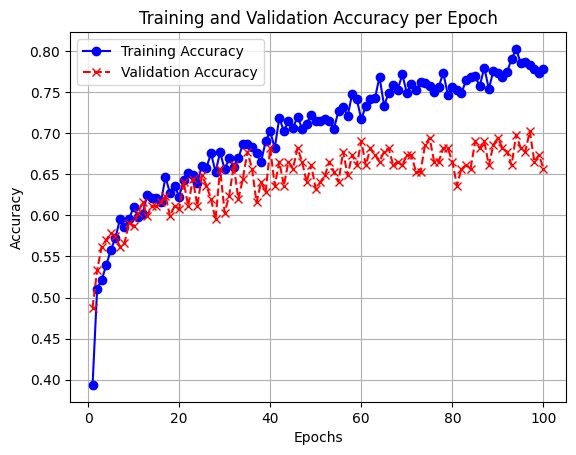

In [63]:
import matplotlib.pyplot as plt

train_acc, val_acc = model.get_train_acc()



x = range(1, len(train_acc) + 1)

# Plot training accuracy
plt.plot(x, train_acc, label='Training Accuracy', color='blue', linestyle='-', marker='o')

# Plot validation accuracy
plt.plot(x, val_acc, label='Validation Accuracy', color='red', linestyle='--', marker='x')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy per Epoch')

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [65]:
import pickle
with open('fullTrainData.pkl', 'wb') as f:
    data = {'train_loader': train_loader, 'val_loader':val_loader, 'train_dataset': train_dataset, 'val_dataset':val_dataset}
    pickle.dump(data, f)